In [50]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from typing import Iterable
import numpy as np
plt.ion()

def spread_voxels(voxels):
    return voxels[:,0],voxels[:,1],voxels[:,2]

def plot_xyz(x:Iterable|np.array=[],y:Iterable|np.array=[],z:Iterable|np.array=[], voxels:np.ndarray=None, ax:Axes=None):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    
    if voxels is None:
        ax.scatter(x,y,z)
    else:
        ax.scatter(*spread_voxels(voxels))
        
    ax.set_aspect('equal','box')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return ax, ax.get_figure()

In [33]:
import csv
from typing import Iterable
import numpy as np

def save_cloud(filepath:str, data:Iterable):
    with open(filepath, 'w', newline='') as fp:
        wr = csv.writer(fp)
        wr.writerows(data)

def read_cloud(filepath:str):
    with open(filepath, newline='') as fp:
        reader = csv.reader(fp)
        x=[]
        y=[]
        z=[]
        for row in reader:
            x_,y_,z_ = row
            x.append(x_)
            y.append(y_)
            z.append(z_)
        xyz = np.array([x,y,z],dtype=float)
        return xyz.T


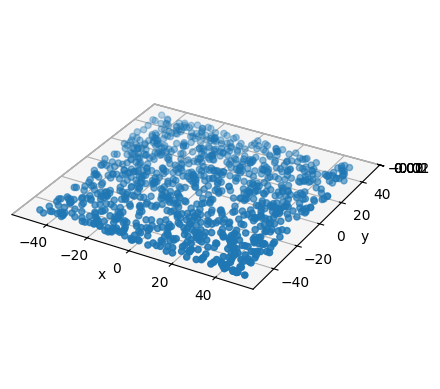

In [51]:
xyz = read_cloud('../clouds/z_plane.xyz')

ax,fig = plot_xyz(voxels=xyz)


In [36]:
def fit_plane(voxels, iterations=50, inlier_thresh=10):  # voxels : x,y,z
    inliers, planes = [], []
    xy1 = np.concatenate([voxels[:, :-1], np.ones((voxels.shape[0], 1))], axis=1)
    z = voxels[:, -1].reshape(-1, 1)
    for _ in range(iterations):
        random_pts = voxels[np.random.choice(voxels.shape[0], voxels.shape[1] * 10, replace=False), :]
        plane_transformation, residual = fit_pts_to_plane(random_pts)
        inliers.append(((z - np.matmul(xy1, plane_transformation)) <= inlier_thresh).sum())
        planes.append(plane_transformation)
    return planes[np.array(inliers).argmax()]


def fit_pts_to_plane(voxels):  # x y z  (m x 3)
    # https://math.stackexchange.com/questions/99299/best-fitting-plane-given-a-set-of-points
    xy1 = np.concatenate([voxels[:, :-1], np.ones((voxels.shape[0], 1))], axis=1)
    z = voxels[:, -1].reshape(-1, 1)
    fit = np.matmul(np.matmul(np.linalg.inv(np.matmul(xy1.T, xy1)), xy1.T), z)
    errors = z - np.matmul(xy1, fit)
    residual = np.linalg.norm(errors)
    return fit, residual

In [45]:
fit = fit_plane(xyz)

In [54]:
from scipy.stats import uniform
n_points = 1000; size = 40

x = uniform.rvs(size=n_points, loc=-size/2, scale=size)
y = uniform.rvs(size=n_points, loc=-size/2, scale=size)

xy1 = np.column_stack([x,y, np.ones(shape=(n_points))])
z = np.matmul(xy1, fit)

ax, fig = plot_xyz(x,y,z, ax=ax)
fig.canvas.draw()

In [7]:
from copy import copy
import numpy as np
from numpy.random import default_rng
rng = default_rng()

class RANSAC:
    def __init__(self, n=10, k=100, t=0.05, d=10, model=None, loss=None, metric=None):
        self.n = n              # `n`: Minimum number of data points to estimate parameters
        self.k = k              # `k`: Maximum iterations allowed
        self.t = t              # `t`: Threshold value to determine if points are fit well
        self.d = d              # `d`: Number of close data points required to assert model fits well
        self.model = model      # `model`: class implementing `fit` and `predict`
        self.loss = loss        # `loss`: function of `y_true` and `y_pred` that returns a vector
        self.metric = metric    # `metric`: function of `y_true` and `y_pred` and returns a float
        self.best_fit = None
        self.best_error = np.inf

    def fit(self, xyz):
        for _ in range(self.k):
            ids = rng.permutation(xyz.shape[0])

            maybe_inliers = ids[: self.n]
            maybe_model = copy(self.model).fit(xyz[maybe_inliers])

            thresholded = (
                self.loss(xyz[ids][self.n :], maybe_model.predict(xyz[ids][self.n :]))
                < self.t
            )

            inlier_ids = ids[self.n :][np.flatnonzero(thresholded).flatten()]

            if inlier_ids.size > self.d:
                inlier_points = np.hstack([maybe_inliers, inlier_ids])
                better_model = copy(self.model).fit(xyz[inlier_points], y[inlier_points])

                this_error = self.metric(
                    y[inlier_points], better_model.predict(xyz[inlier_points])
                )

                if this_error < self.best_error:
                    self.best_error = this_error
                    self.best_fit = better_model

        return self

    def predict(self, X):
        return self.best_fit.predict(X)

def square_error_loss(y_true, y_pred):
    return (y_true - y_pred) ** 2


def mean_square_error(y_true, y_pred):
    return np.sum(square_error_loss(y_true, y_pred)) / y_true.shape[0]


class PlaneRegressor:
    def __init__(self):
        self.params = None

    def fit(self, xyz: np.ndarray, y: np.ndarray):
        z = np.matrix(xyz[:,-1]).T
        xy1 = np.hstack([xyz[:,0:-1], np.ones((xyz.shape[0],1))])
        fit = (xy1.T * xy1).I * xy1.T * z
        errors = z - xy1 * fit
        residual = np.linalg.norm(errors)
        self.params = fit
        self.residual = residual
        return self

    def predict(self, xy: np.ndarray):
        X = np.hstack([xy, np.ones((xy.shape[0],1))])
        return X @ self.params


p = PlaneRegressor()



